In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from tqdm.notebook import tqdm

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from src.signal_categories import topological_category_labels, topological_category_colors
from src.signal_categories import physics_category_labels, physics_category_colors
from src.signal_categories import filetype_category_labels, filetype_category_colors


In [2]:
import umap
import sklearn
from sklearn.preprocessing import StandardScaler

from sklearn.manifold import TSNE, MDS, Isomap
from sklearn.decomposition import PCA, FastICA, NMF
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA


print(f"sklearn version: {sklearn.__version__}")
print(f"umap version: {umap.__version__}")


sklearn version: 1.3.0
umap version: 0.5.4


In [3]:
#training = "first_combined_training"
training = "first_wc_training"
#training = "first_lantern_training"


# File Loading

In [4]:
print("loading all_df.pkl...")
with open(f"../intermediate_files/all_df.pkl", "rb") as f:
    all_df = pickle.load(f)
print(f"{all_df.shape=}")

# this only includes predictions for events passing the preselection used during training
print("loading predictions.pkl...")
with open(f"../training_outputs/{training}/predictions.pkl", "rb") as f:
    pred_df = pickle.load(f)
print(f"{pred_df.shape=}")

print("merging all_df and predictions.pkl...")
merged_df = pd.merge(all_df, pred_df, on=["filetype", "run", "subrun", "event"], how="left")

sig_categories = topological_category_labels

prob_categories = ["prob_" + cat for cat in sig_categories]

for prob in prob_categories:
    merged_df[prob] = merged_df[prob].fillna(-1)

num_train_events = len(merged_df.query("used_for_training == True"))
num_test_events = len(merged_df.query("used_for_testing == True"))
frac_test = num_test_events / (num_train_events + num_test_events)
print(f"weighting up by the fraction of test events: {frac_test:.3f}")

modified_net_weights = []
used_for_testing = merged_df["used_for_testing"].to_numpy()
wc_net_weights = merged_df["wc_net_weight"].to_numpy()
for i in range(len(merged_df)):
    if used_for_testing[i]:
        modified_net_weights.append(wc_net_weights[i] / frac_test)
    else:
        modified_net_weights.append(wc_net_weights[i])
merged_df["wc_net_weight"] = modified_net_weights         

merged_df = merged_df.query("used_for_testing == True")

print(f"{merged_df.shape=}")
presel_merged_df = merged_df.query("wc_kine_reco_Enu > 0 and wc_shw_sp_n_20mev_showers > 0")
print(f"{presel_merged_df.shape=}")

presel_merged_df


loading all_df.pkl...
all_df.shape=(747332, 191)
loading predictions.pkl...
pred_df.shape=(71178, 22)
merging all_df and predictions.pkl...
weighting up by the fraction of test events: 0.500
merged_df.shape=(35589, 209)
presel_merged_df.shape=(24065, 209)


,wc_nc_delta_score,wc_nc_pio_score,wc_kine_reco_Enu,wc_match_isFC,wc_shw_sp_n_20mev_showers,wc_nue_score,wc_numu_score,wc_truth_NprimPio,wc_truth_NCDelta,wc_reco_nuvtxX,...,prob_2g0p,prob_2gNp1mu,prob_2g0p1mu,prob_2g_outFV,prob_1eNp,prob_1e0p,prob_0g,prob_3plusg,prob_dirt,prob_ext
0,-3.342609,3.510125,614.294678,True,2.0,-15.000000,-0.445759,1.0,0.0,235.407227,...,0.019142,0.017800,0.003256,0.000289,0.000030,0.000003,0.011870,0.005165,0.000707,0.025118
1,-6.305526,3.168464,563.121155,True,3.0,-8.405992,-0.906318,1.0,0.0,156.138885,...,0.004249,0.125676,0.000655,0.000049,0.000035,0.000007,0.004708,0.021230,0.000153,0.009672
4,-7.236095,5.160080,419.250702,False,2.0,-9.779932,-1.000641,1.0,0.0,144.645752,...,0.618312,0.131866,0.006751,0.008768,0.000083,0.000079,0.031507,0.004851,0.003354,0.065762
5,1.638694,2.628025,504.538116,True,1.0,-15.000000,-0.130912,1.0,0.0,79.231628,...,0.023291,0.011491,0.000609,0.000048,0.000008,0.000004,0.076857,0.003097,0.000219,0.003777
7,-3.236898,2.573358,417.981934,False,2.0,-13.695713,-0.727442,1.0,0.0,95.053276,...,0.801539,0.011555,0.003526,0.003090,0.000043,0.000019,0.002192,0.004402,0.000955,0.019349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745925,-3.114151,-3.512204,334.598816,False,1.0,-15.000000,-0.032794,NaN,NaN,60.771526,...,0.000876,0.003355,0.000107,0.000018,0.000004,0.000003,0.590949,0.000023,0.012433,0.386874
746371,-1.905209,-0.807734,101.547508,True,1.0,-15.000000,-0.938013,NaN,NaN,51.878151,...,0.018804,0.000627,0.000036,0.000062,0.000009,0.000005,0.226412,0.000110,0.409959,0.321829
746558,-4.554944,-0.041014,184.437103,False,1.0,-15.000000,-3.454599,NaN,NaN,107.533432,...,0.003780,0.000206,0.000080,0.000090,0.000015,0.000003,0.059708,0.000082,0.090062,0.839659
746934,-5.872269,-4.388559,542.516235,True,1.0,-15.000000,-0.014429,NaN,NaN,145.772400,...,0.004435,0.001430,0.000697,0.000014,0.000012,0.000003,0.364652,0.000172,0.005169,0.618828


In [5]:
probs_2d_arr = presel_merged_df[prob_categories].to_numpy()

reco_categories_argmax = np.argmax(probs_2d_arr, axis=1)

presel_merged_df["reco_category_argmax_index"] = reco_categories_argmax


/var/folders/yg/3cj9svrx2kz3bpv_6thtt7x00000gn/T/ipykernel_87607/4263806371.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  presel_merged_df["reco_category_argmax_index"] = reco_categories_argmax


# Multi-Class Probability Visualization

In [6]:
#scaler = StandardScaler()
#probs_scaled = scaler.fit_transform(probs_2d_arr)
probs_scaled = probs_2d_arr

reducer = umap.UMAP(random_state=42)

reducer.fit(probs_scaled)
umap_result = reducer.transform(probs_scaled)


/opt/homebrew/Caskroom/miniconda/base/envs/base_2/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


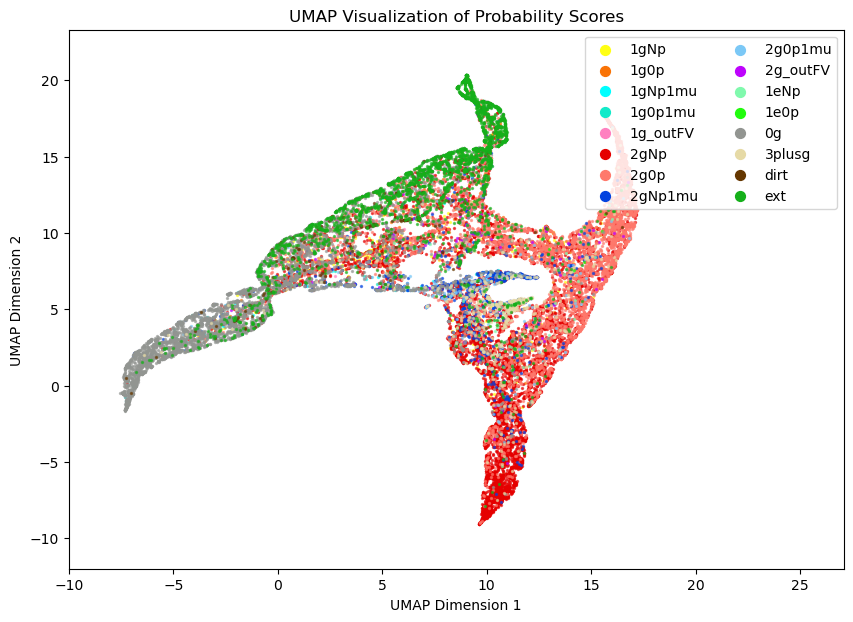

In [7]:
true_sig_categories = presel_merged_df["topological_signal_category"].to_numpy()
plt.figure(figsize=(10, 7))
for i in range(len(sig_categories)):
    true_sig_category_mask = true_sig_categories == sig_categories[i]
    plt.scatter(umap_result[true_sig_category_mask, 0], umap_result[true_sig_category_mask, 1], alpha=0.6, s=2, c=topological_category_colors[i])
    plt.scatter([], [], s=50, c=topological_category_colors[i], label=sig_categories[i])
plt.title('UMAP Visualization of Probability Scores')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
min_x, max_x = umap_result[:, 0].min(), umap_result[:, 0].max()
min_y, max_y = umap_result[:, 1].min(), umap_result[:, 1].max()
x_diff = max_x - min_x
y_diff = max_y - min_y
plt.xlim(min_x - x_diff * 0.1, max_x + x_diff * 0.4)
plt.ylim(min_y - y_diff * 0.1, max_y + y_diff * 0.1)
plt.legend(loc="upper right", ncol=2)
plt.savefig(f"../training_outputs/{training}/score_vis/umap_visualization.png")


In [8]:
"""tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(probs_scaled)
plt.figure(figsize=(10, 7))
for i in range(len(sig_categories)):
    true_sig_category_mask = true_sig_categories == sig_categories[i]
    plt.scatter(tsne_result[true_sig_category_mask, 0], tsne_result[true_sig_category_mask, 1], alpha=0.6, s=10, c=topological_category_colors[i])
    plt.scatter([], [], s=50, c=topological_category_colors[i], label=sig_categories[i])
plt.title('t-SNE')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
min_x, max_x = tsne_result[:, 0].min(), tsne_result[:, 0].max()
min_y, max_y = tsne_result[:, 1].min(), tsne_result[:, 1].max()
x_diff = max_x - min_x
y_diff = max_y - min_y
plt.xlim(min_x - x_diff * 0.1, max_x + x_diff * 0.4)
plt.ylim(min_y - y_diff * 0.1, max_y + y_diff * 0.1)
plt.legend(loc="upper right", ncol=2)
plt.savefig(f"../training_outputs/{training}/score_vis/tsne_visualization.png")
"""

'tsne = TSNE(n_components=2, random_state=42)\ntsne_result = tsne.fit_transform(probs_scaled)\nplt.figure(figsize=(10, 7))\nfor i in range(len(sig_categories)):\n    true_sig_category_mask = true_sig_categories == sig_categories[i]\n    plt.scatter(tsne_result[true_sig_category_mask, 0], tsne_result[true_sig_category_mask, 1], alpha=0.6, s=10, c=topological_category_colors[i])\n    plt.scatter([], [], s=50, c=topological_category_colors[i], label=sig_categories[i])\nplt.title(\'t-SNE\')\nplt.xlabel(\'t-SNE Dimension 1\')\nplt.ylabel(\'t-SNE Dimension 2\')\nmin_x, max_x = tsne_result[:, 0].min(), tsne_result[:, 0].max()\nmin_y, max_y = tsne_result[:, 1].min(), tsne_result[:, 1].max()\nx_diff = max_x - min_x\ny_diff = max_y - min_y\nplt.xlim(min_x - x_diff * 0.1, max_x + x_diff * 0.4)\nplt.ylim(min_y - y_diff * 0.1, max_y + y_diff * 0.1)\nplt.legend(loc="upper right", ncol=2)\nplt.savefig(f"../training_outputs/{training}/score_vis/tsne_visualization.png")\n'

In [9]:
# too slow
"""
mds = MDS(n_components=2, random_state=42)
mds_result = mds.fit_transform(probs_scaled)
plt.figure(figsize=(10, 7))
for i in range(len(sig_categories)):
    true_sig_category_mask = true_sig_categories == sig_categories[i]
    plt.scatter(mds_result[true_sig_category_mask, 0], mds_result[true_sig_category_mask, 1], alpha=0.6, s=10, c=topological_category_colors[i])
    plt.scatter([], [], s=50, c=topological_category_colors[i], label=sig_categories[i])
plt.title('MDS')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
min_x, max_x = mds_result[:, 0].min(), mds_result[:, 0].max()
min_y, max_y = mds_result[:, 1].min(), mds_result[:, 1].max()
x_diff = max_x - min_x
y_diff = max_y - min_y
plt.xlim(min_x - x_diff * 0.1, max_x + x_diff * 0.4)
plt.ylim(min_y - y_diff * 0.1, max_y + y_diff * 0.1)
plt.legend(loc="upper right", ncol=2)
plt.savefig(f"../training_outputs/{training}/mds_visualization.png")
"""
pass

In [10]:
"""pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(probs_scaled)
plt.figure(figsize=(10, 7))
for i in range(len(sig_categories)):
    true_sig_category_mask = true_sig_categories == sig_categories[i]
    plt.scatter(pca_result[true_sig_category_mask, 0], pca_result[true_sig_category_mask, 1], alpha=0.6, s=10, c=topological_category_colors[i])
    plt.scatter([], [], s=50, c=topological_category_colors[i], label=sig_categories[i])
plt.title('PCA')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
min_x, max_x = pca_result[:, 0].min(), pca_result[:, 0].max()
min_y, max_y = pca_result[:, 1].min(), pca_result[:, 1].max()
x_diff = max_x - min_x
y_diff = max_y - min_y
plt.xlim(min_x - x_diff * 0.1, max_x + x_diff * 0.4)
plt.ylim(min_y - y_diff * 0.1, max_y + y_diff * 0.1)
plt.legend(loc="upper right", ncol=2)
plt.savefig(f"../training_outputs/{training}/score_vis/pca_visualization.png")
"""

'pca = PCA(n_components=2, random_state=42)\npca_result = pca.fit_transform(probs_scaled)\nplt.figure(figsize=(10, 7))\nfor i in range(len(sig_categories)):\n    true_sig_category_mask = true_sig_categories == sig_categories[i]\n    plt.scatter(pca_result[true_sig_category_mask, 0], pca_result[true_sig_category_mask, 1], alpha=0.6, s=10, c=topological_category_colors[i])\n    plt.scatter([], [], s=50, c=topological_category_colors[i], label=sig_categories[i])\nplt.title(\'PCA\')\nplt.xlabel(\'PCA Dimension 1\')\nplt.ylabel(\'PCA Dimension 2\')\nmin_x, max_x = pca_result[:, 0].min(), pca_result[:, 0].max()\nmin_y, max_y = pca_result[:, 1].min(), pca_result[:, 1].max()\nx_diff = max_x - min_x\ny_diff = max_y - min_y\nplt.xlim(min_x - x_diff * 0.1, max_x + x_diff * 0.4)\nplt.ylim(min_y - y_diff * 0.1, max_y + y_diff * 0.1)\nplt.legend(loc="upper right", ncol=2)\nplt.savefig(f"../training_outputs/{training}/score_vis/pca_visualization.png")\n'

In [11]:
# too slow
"""
isomap = Isomap(n_components=2, n_neighbors=10)
isomap_result = isomap.fit_transform(probs_scaled)
plt.figure(figsize=(10, 7))
for i in range(len(sig_categories)):
    true_sig_category_mask = true_sig_categories == sig_categories[i]
    plt.scatter(isomap_result[true_sig_category_mask, 0], isomap_result[true_sig_category_mask, 1], alpha=0.6, s=10, c=topological_category_colors[i])
    plt.scatter([], [], s=50, c=topological_category_colors[i], label=sig_categories[i])
plt.title('Isomap')
plt.xlabel('Isomap Dimension 1')
plt.ylabel('Isomap Dimension 2')
min_x, max_x = isomap_result[:, 0].min(), isomap_result[:, 0].max()
min_y, max_y = isomap_result[:, 1].min(), isomap_result[:, 1].max()
x_diff = max_x - min_x
y_diff = max_y - min_y
plt.xlim(min_x - x_diff * 0.1, max_x + x_diff * 0.4)
plt.ylim(min_y - y_diff * 0.1, max_y + y_diff * 0.1)
plt.legend(loc="upper right", ncol=2)
plt.savefig(f"../training_outputs/{training}/score_vis/isomap_visualization.png")
"""
pass

In [12]:
"""fastica = FastICA(n_components=2, random_state=42)
fastica_result = fastica.fit_transform(probs_scaled)
plt.figure(figsize=(10, 7))
for i in range(len(sig_categories)):
    true_sig_category_mask = true_sig_categories == sig_categories[i]
    plt.scatter(fastica_result[true_sig_category_mask, 0], fastica_result[true_sig_category_mask, 1], alpha=0.6, s=10, c=topological_category_colors[i])
    plt.scatter([], [], s=50, c=topological_category_colors[i], label=sig_categories[i])
plt.title('FastICA')
plt.xlabel('FastICA Dimension 1')
plt.ylabel('FastICA Dimension 2')
min_x, max_x = fastica_result[:, 0].min(), fastica_result[:, 0].max()
min_y, max_y = fastica_result[:, 1].min(), fastica_result[:, 1].max()
x_diff = max_x - min_x
y_diff = max_y - min_y
plt.xlim(min_x - x_diff * 0.1, max_x + x_diff * 0.5)
plt.ylim(min_y - y_diff * 0.1, max_y + y_diff * 0.1)
plt.legend(loc="upper right", ncol=2)
plt.savefig(f"../training_outputs/{training}/score_vis/fastica_visualization.png")
"""

'fastica = FastICA(n_components=2, random_state=42)\nfastica_result = fastica.fit_transform(probs_scaled)\nplt.figure(figsize=(10, 7))\nfor i in range(len(sig_categories)):\n    true_sig_category_mask = true_sig_categories == sig_categories[i]\n    plt.scatter(fastica_result[true_sig_category_mask, 0], fastica_result[true_sig_category_mask, 1], alpha=0.6, s=10, c=topological_category_colors[i])\n    plt.scatter([], [], s=50, c=topological_category_colors[i], label=sig_categories[i])\nplt.title(\'FastICA\')\nplt.xlabel(\'FastICA Dimension 1\')\nplt.ylabel(\'FastICA Dimension 2\')\nmin_x, max_x = fastica_result[:, 0].min(), fastica_result[:, 0].max()\nmin_y, max_y = fastica_result[:, 1].min(), fastica_result[:, 1].max()\nx_diff = max_x - min_x\ny_diff = max_y - min_y\nplt.xlim(min_x - x_diff * 0.1, max_x + x_diff * 0.5)\nplt.ylim(min_y - y_diff * 0.1, max_y + y_diff * 0.1)\nplt.legend(loc="upper right", ncol=2)\nplt.savefig(f"../training_outputs/{training}/score_vis/fastica_visualization

In [13]:
"""nmf = NMF(n_components=2, random_state=42)
nmf_result = nmf.fit_transform(probs_scaled)
plt.figure(figsize=(10, 7))
for i in range(len(sig_categories)):
    true_sig_category_mask = true_sig_categories == sig_categories[i]
    plt.scatter(nmf_result[true_sig_category_mask, 0], nmf_result[true_sig_category_mask, 1], alpha=0.6, s=10, c=topological_category_colors[i])
    plt.scatter([], [], s=50, c=topological_category_colors[i], label=sig_categories[i])
plt.title('NMF')
plt.xlabel('NMF Dimension 1')
plt.ylabel('NMF Dimension 2')
min_x, max_x = nmf_result[:, 0].min(), nmf_result[:, 0].max()
min_y, max_y = nmf_result[:, 1].min(), nmf_result[:, 1].max()
x_diff = max_x - min_x
y_diff = max_y - min_y
plt.xlim(min_x - x_diff * 0.1, max_x + x_diff * 0.4)
plt.ylim(min_y - y_diff * 0.1, max_y + y_diff * 0.1)
plt.legend(loc="upper right", ncol=2)
plt.savefig(f"../training_outputs/{training}/score_vis/nmf_visualization.png")
"""

'nmf = NMF(n_components=2, random_state=42)\nnmf_result = nmf.fit_transform(probs_scaled)\nplt.figure(figsize=(10, 7))\nfor i in range(len(sig_categories)):\n    true_sig_category_mask = true_sig_categories == sig_categories[i]\n    plt.scatter(nmf_result[true_sig_category_mask, 0], nmf_result[true_sig_category_mask, 1], alpha=0.6, s=10, c=topological_category_colors[i])\n    plt.scatter([], [], s=50, c=topological_category_colors[i], label=sig_categories[i])\nplt.title(\'NMF\')\nplt.xlabel(\'NMF Dimension 1\')\nplt.ylabel(\'NMF Dimension 2\')\nmin_x, max_x = nmf_result[:, 0].min(), nmf_result[:, 0].max()\nmin_y, max_y = nmf_result[:, 1].min(), nmf_result[:, 1].max()\nx_diff = max_x - min_x\ny_diff = max_y - min_y\nplt.xlim(min_x - x_diff * 0.1, max_x + x_diff * 0.4)\nplt.ylim(min_y - y_diff * 0.1, max_y + y_diff * 0.1)\nplt.legend(loc="upper right", ncol=2)\nplt.savefig(f"../training_outputs/{training}/score_vis/nmf_visualization.png")\n'